In [1]:
import numpy as np
import keras
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import datetime
import scipy.stats as ss

# Data loading

In [2]:
starbucks_data = pd.read_csv('starbucks_data.csv')

In [3]:
starbucks_data

,Date,Close/Last,Volume,Open,High,Low
0,06/07/2024,$81.43,10852600,$81.62,$82.63,$80.61
1,06/06/2024,$81.47,9237764,$81.15,$82.93,$80.92
2,06/05/2024,$81.16,11275340,$82.46,$82.50,$80.96
3,06/04/2024,$82.79,12369950,$81.97,$83.43,$81.90
4,06/03/2024,$82.08,12443410,$79.68,$82.12,$79.62
...,...,...,...,...,...,...
1254,06/14/2019,$84.24,9226463,$83.54,$84.61,$83.39
1255,06/13/2019,$83.35,7156842,$83.33,$84.05,$83.02
1256,06/12/2019,$82.93,6089028,$82.59,$83.67,$82.32
1257,06/11/2019,$82.37,6226559,$82.30,$82.86,$81.85


Change date type to datetime (for sorting)

In [4]:
starbucks_data['Date'] = pd.to_datetime(starbucks_data['Date'])

In [5]:
starbucks_data.sort_values('Date', inplace=True)
starbucks_data.reset_index(drop=True, inplace=True)

In [6]:
starbucks_data = starbucks_data.loc[starbucks_data['Date']<='2024-05-24']
starbucks_data

,Date,Close/Last,Volume,Open,High,Low
0,2019-06-10,$81.93,8102783,$82.85,$82.86,$81.38
1,2019-06-11,$82.37,6226559,$82.30,$82.86,$81.85
2,2019-06-12,$82.93,6089028,$82.59,$83.67,$82.32
3,2019-06-13,$83.35,7156842,$83.33,$84.05,$83.02
4,2019-06-14,$84.24,9226463,$83.54,$84.61,$83.39
...,...,...,...,...,...,...
1245,2024-05-20,$77.54,11183770,$77.68,$78.32,$76.71
1246,2024-05-21,$77.72,8916627,$77.555,$78.215,$77.50
1247,2024-05-22,$80.72,22072210,$77.70,$81.02,$77.44
1248,2024-05-23,$78.305,15841330,$80.10,$80.70,$77.64


In [7]:
starbucks_data.loc[starbucks_data['Date']=='2023-05-30']

,Date,Close/Last,Volume,Open,High,Low
1000,2023-05-30,$97.75,6505373,$98.89,$98.96,$97.305


Starbucks Corporation Common Stock (SBUX) Historical Quotes: https://www.nasdaq.com/market-activity/stocks/sbux/historical?page=1&rows_per_page=10&timeline=y5

Starbucks stock price data from $10.06.2019$ till $24.05.2024$. 

We're going to split this time series into train and test set. Test set will contain data starting $30.05.2023$. That means that training set will contain observations $[0,999]$ and test set $[1000, 1249]$.

In [8]:
select_data = starbucks_data['Close/Last']

# EDA

In [9]:
select_data

0        $81.93
1        $82.37
2        $82.93
3        $83.35
4        $84.24
         ...   
1245     $77.54
1246     $77.72
1247     $80.72
1248    $78.305
1249     $78.87
Name: Close/Last, Length: 1250, dtype: object

In [10]:
select_data = select_data.str.replace('$', '').astype(float)
select_data

0       81.930
1       82.370
2       82.930
3       83.350
4       84.240
         ...  
1245    77.540
1246    77.720
1247    80.720
1248    78.305
1249    78.870
Name: Close/Last, Length: 1250, dtype: float64

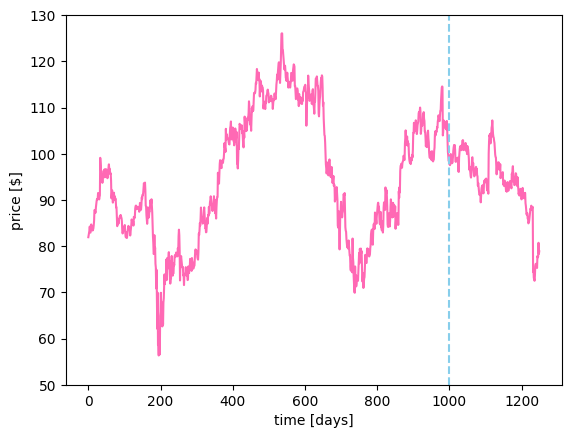

In [11]:
plt.plot(select_data, color='hotpink')
plt.vlines(1000, ymin=50, ymax=130, color='skyblue', linestyles='--')
plt.ylim([50,130])
plt.xlabel('time [days]')
plt.ylabel('price [$]')
plt.show()

In [12]:
select_data.info()

<class 'pandas.core.series.Series'>
Index: 1250 entries, 0 to 1249
Series name: Close/Last
Non-Null Count  Dtype  
--------------  -----  
1250 non-null   float64
dtypes: float64(1)
memory usage: 19.5 KB


In [13]:
select_data.describe()

count    1250.000000
mean       94.405620
std        13.030376
min        56.330000
25%        85.042500
50%        93.830000
75%       104.322500
max       126.060000
Name: Close/Last, dtype: float64

In [14]:
scaled_data = (select_data - select_data.mean())/select_data.std()

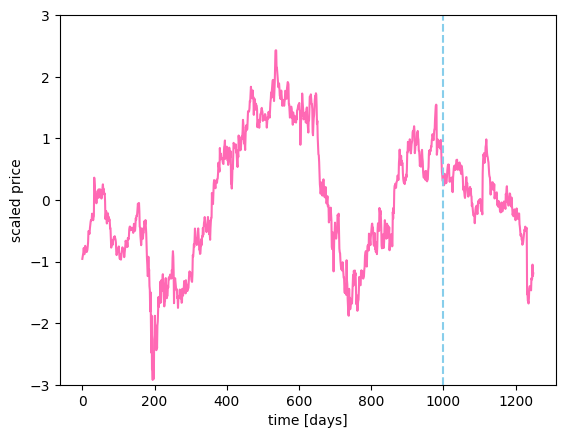

In [15]:
plt.plot(scaled_data, color='hotpink')
plt.vlines(1000, ymin=-3, ymax=3, color='skyblue', linestyles='--')
plt.ylim([-3,3])
plt.xlabel('time [days]')
plt.ylabel('scaled price')
plt.show()

In [16]:
scaled_data.info()

<class 'pandas.core.series.Series'>
Index: 1250 entries, 0 to 1249
Series name: Close/Last
Non-Null Count  Dtype  
--------------  -----  
1250 non-null   float64
dtypes: float64(1)
memory usage: 19.5 KB


In [17]:
scaled_data.describe()

count    1.250000e+03
mean    -1.045919e-15
std      1.000000e+00
min     -2.922066e+00
25%     -7.185610e-01
50%     -4.417524e-02
75%      7.610586e-01
max      2.429276e+00
Name: Close/Last, dtype: float64

In [18]:
ss.shapiro(scaled_data)

ShapiroResult(statistic=0.9877887964248657, pvalue=1.0175780218446562e-08)

We can check normality of the increments in time

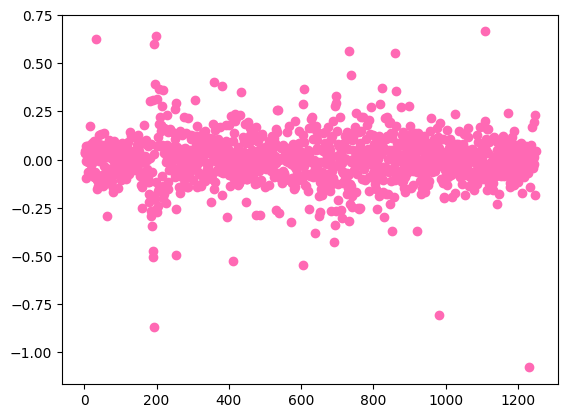

In [19]:
plt.scatter(range(1,1250), scaled_data.diff()[1:], color='hotpink')
plt.show()

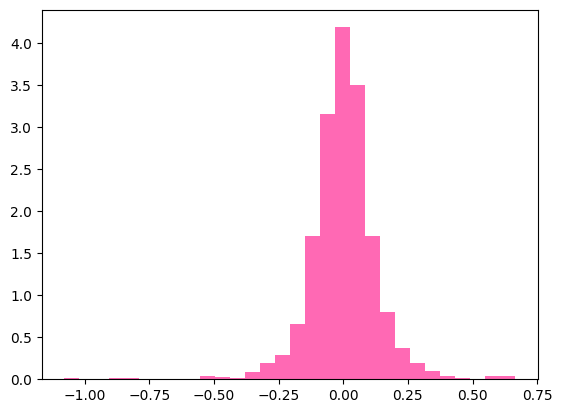

In [20]:
plt.hist(scaled_data.diff()[1:], density=True, bins=30, color='hotpink')
plt.show()

In [21]:
ss.shapiro(scaled_data.diff()[1:])

ShapiroResult(statistic=0.9123842716217041, pvalue=3.115771621071208e-26)

## Split data into train and test set

In [22]:
train_set = scaled_data[:1000].values
test_set = scaled_data[1000:].values
print(f'Train set length: {train_set.shape}')
print(f'Test set length: {test_set.shape}')

Train set length: (1000,)
Test set length: (250,)


In [23]:
x_train = []
y_train = []
window_size = 50
for i in range(len(train_set)-window_size):
    x_train.append(train_set[i:(i + window_size)])
    y_train.append(train_set[window_size+i])

In [24]:
x_train = np.array(x_train)
y_train = np.array(y_train).transpose()

In [25]:
x_train.shape

(950, 50)

In [26]:
x_test = []
y_test = []
window_size = 50
for i in range(len(test_set)-window_size):
    x_test.append(test_set[i:(i + window_size)])
    y_test.append(test_set[window_size+i])
x_test = np.array(x_test)
y_test = np.matrix(y_test).transpose()

In [27]:
y_test.shape

(200, 1)

# RNN

## SimpleRNN

In [271]:
Model_Simple= keras.Sequential()
Model_Simple.add(keras.layers.SimpleRNN(128, input_shape=(x_train.shape[1],1), return_sequences=True ))
Model_Simple.add(keras.layers.Dropout(0.2))
Model_Simple.add(keras.layers.SimpleRNN(128))
Model_Simple.add(keras.layers.Dense(1))

In [272]:
Model_Simple.compile(optimizer='adam',
            loss='mse',
            metrics=['mae'])

In [273]:
simple_rnn = Model_Simple.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test))

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.3485 - mae: 0.4197 - val_loss: 0.0779 - val_mae: 0.2241
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0547 - mae: 0.1814 - val_loss: 0.0272 - val_mae: 0.1135
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0388 - mae: 0.1509 - val_loss: 0.0286 - val_mae: 0.1214
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0292 - mae: 0.1315 - val_loss: 0.0175 - val_mae: 0.0853
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0269 - mae: 0.1242 - val_loss: 0.0196 - val_mae: 0.0986
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0242 - mae: 0.1169 - val_loss: 0.0199 - val_mae: 0.0945
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0270 - mae: 0.1265 - val_loss: 0.0239 - val_mae: 0.1035
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0241 - mae: 0.1198 - val_loss: 0.0182 - val_mae: 0.0899
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.030

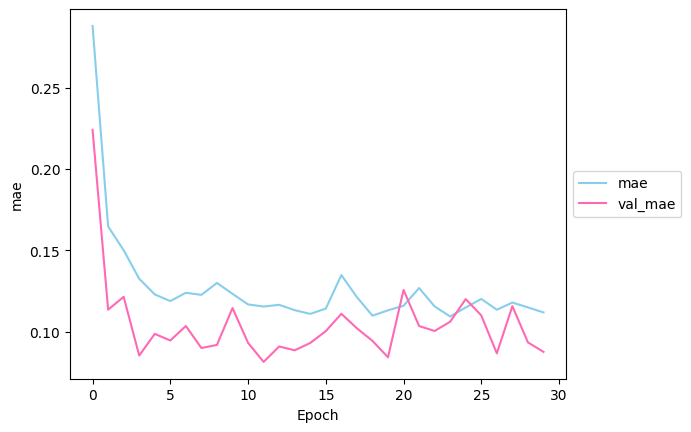

In [274]:
plt.plot(simple_rnn.history['mae'], label='mae', color='skyblue')
plt.plot(simple_rnn.history['val_mae'], label = 'val_mae', color='hotpink')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

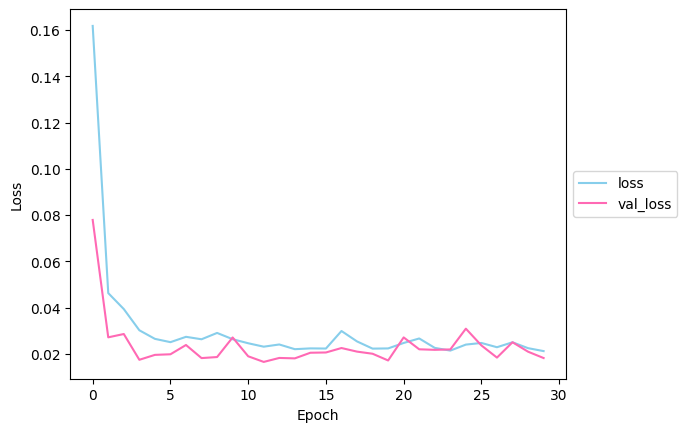

In [277]:
plt.plot(simple_rnn.history['loss'], label='loss', color='skyblue')
plt.plot(simple_rnn.history['val_loss'], label = 'val_loss', color='hotpink')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


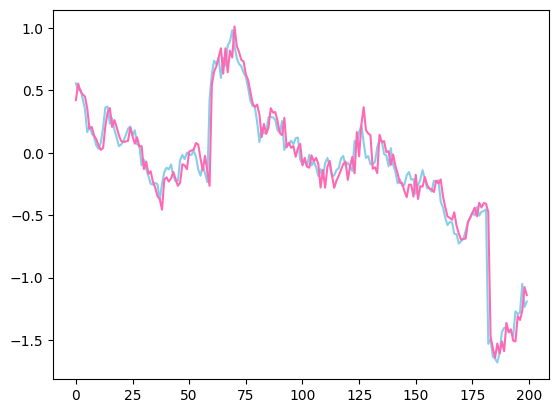

In [279]:
y_pred = Model_Simple.predict(x_test)
plt.plot(y_test, label='actual', color='skyblue')
plt.plot(y_pred, label='predicted', color='hotpink')

## LSTM

In [29]:
Model_LSTM= keras.Sequential()
Model_LSTM.add(keras.layers.LSTM(128, input_shape=(x_train.shape[1],1), return_sequences=True ))
Model_LSTM.add(keras.layers.Dropout(0.2))
Model_LSTM.add(keras.layers.LSTM(128))
Model_LSTM.add(keras.layers.Dense(1))
Model_LSTM.compile(optimizer='adam',
            loss='mse',
            metrics=['mae'])

In [30]:
lstm_rnn = Model_LSTM.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test))

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - loss: 0.4536 - mae: 0.4804 - val_loss: 0.0537 - val_mae: 0.1578
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - loss: 0.0660 - mae: 0.1954 - val_loss: 0.0581 - val_mae: 0.1625
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - loss: 0.0547 - mae: 0.1797 - val_loss: 0.0489 - val_mae: 0.1534
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - loss: 0.0504 - mae: 0.1696 - val_loss: 0.0423 - val_mae: 0.1409
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - loss: 0.0443 - mae: 0.1593 - val_loss: 0.0401 - val_mae: 0.1387
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 0.0429 - mae: 0.1575 - val_loss: 0.0355 - val_mae: 0.1290
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.0434 - mae: 0.1575 - val_loss: 0.0359 - val_mae: 0.1313
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 0.0403 - mae: 0.1523 - val_loss: 0.0317 - val_mae: 0.1217
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - l

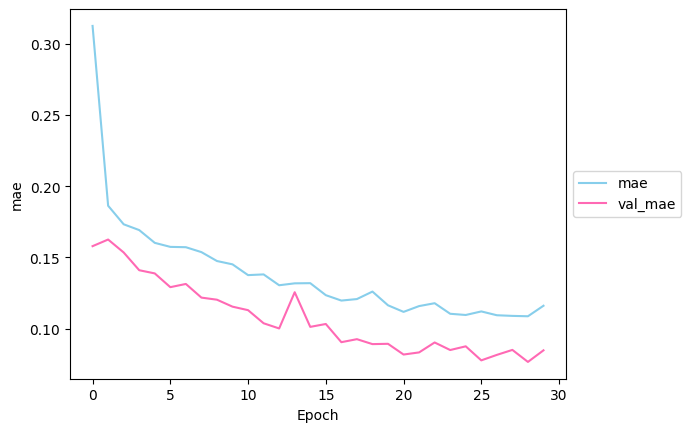

In [33]:
plt.plot(lstm_rnn.history['mae'], label='mae', color='skyblue')
plt.plot(lstm_rnn.history['val_mae'], label = 'val_mae', color='hotpink')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

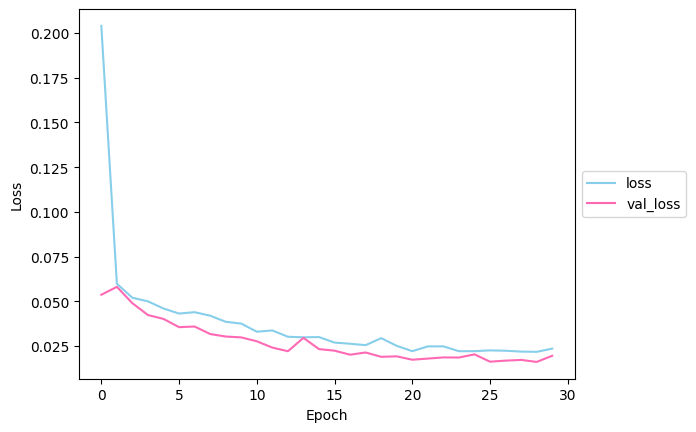

In [34]:
plt.plot(lstm_rnn.history['loss'], label='loss', color='skyblue')
plt.plot(lstm_rnn.history['val_loss'], label = 'val_loss', color='hotpink')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


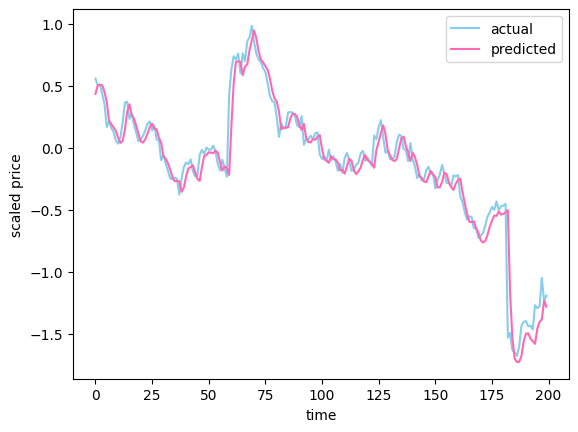

In [37]:
y_pred = Model_LSTM.predict(x_test)
plt.plot(y_test, label='actual', color='skyblue')
plt.plot(y_pred, label='predicted', color='hotpink')
plt.xlabel('time')
plt.ylabel('scaled price')
plt.legend()
plt.show()

## GRU

In [38]:
Model_GRU= keras.Sequential()
Model_GRU.add(keras.layers.GRU(128, input_shape=(x_train.shape[1],1), return_sequences=True ))
Model_GRU.add(keras.layers.Dropout(0.2))
Model_GRU.add(keras.layers.GRU(128))
Model_GRU.add(keras.layers.Dense(1))
Model_GRU.compile(optimizer='adam',
            loss='mse',
            metrics=['mae'])

In [39]:
gru_rnn = Model_GRU.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test))

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - loss: 0.2688 - mae: 0.3582 - val_loss: 0.0339 - val_mae: 0.1224
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 0.0364 - mae: 0.1431 - val_loss: 0.0250 - val_mae: 0.1054
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 0.0324 - mae: 0.1330 - val_loss: 0.0244 - val_mae: 0.1084
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - loss: 0.0355 - mae: 0.1370 - val_loss: 0.0234 - val_mae: 0.1008
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 0.0260 - mae: 0.1223 - val_loss: 0.0222 - val_mae: 0.1026
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 0.0268 - mae: 0.1224 - val_loss: 0.0200 - val_mae: 0.0910
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.0237 - mae: 0.1126 - val_loss: 0.0199 - val_mae: 0.0939
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 0.0254 - mae: 0.1222 - val_loss: 0.0185 - val_mae: 0.0876
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - l

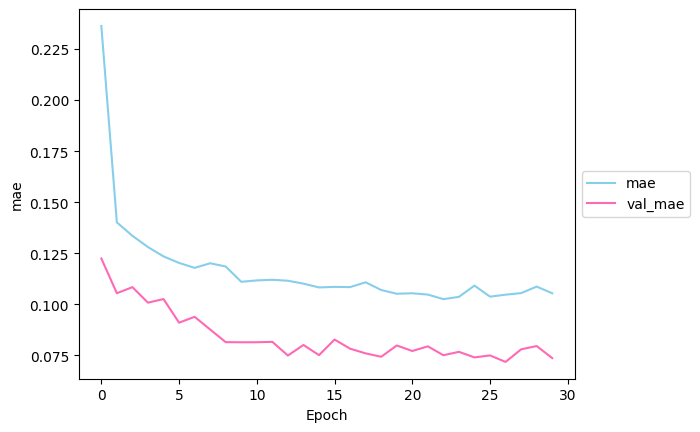

In [40]:
plt.plot(gru_rnn.history['mae'], label='mae', color='skyblue')
plt.plot(gru_rnn.history['val_mae'], label = 'val_mae', color='hotpink')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

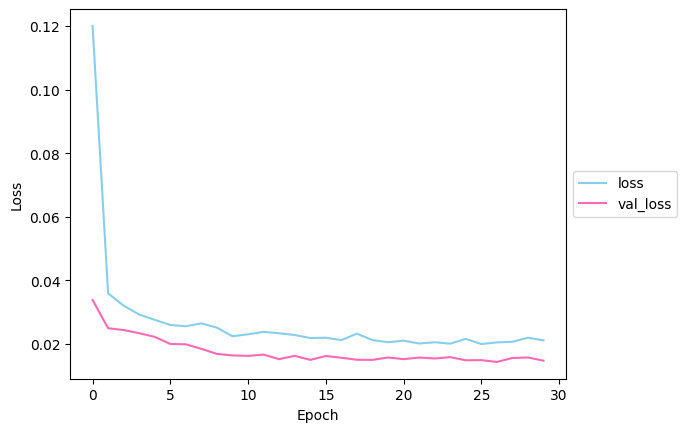

In [41]:
plt.plot(gru_rnn.history['loss'], label='loss', color='skyblue')
plt.plot(gru_rnn.history['val_loss'], label = 'val_loss', color='hotpink')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step


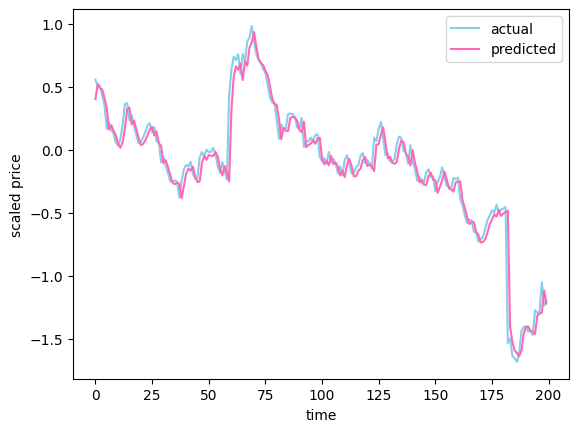

In [42]:
y_pred = Model_GRU.predict(x_test)
plt.plot(y_test, label='actual', color='skyblue')
plt.plot(y_pred, label='predicted', color='hotpink')
plt.xlabel('time')
plt.ylabel('scaled price')
plt.legend()
plt.show()

## Compare base models

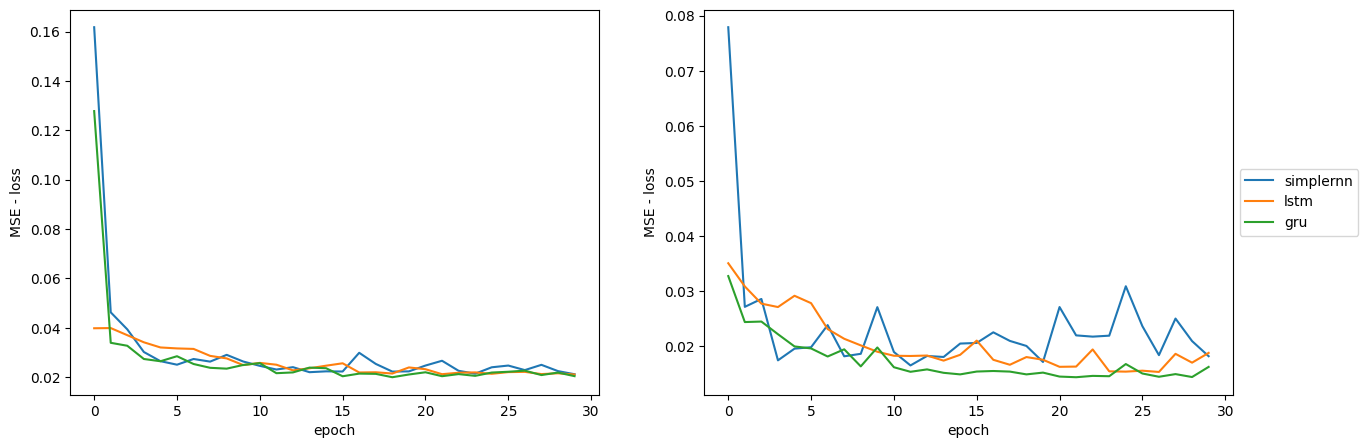

In [306]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(simple_rnn.history['loss'], label='simplernn')
axes[0].plot(lstm_rnn.history['loss'], label='lstm')
axes[0].plot(gru_rnn.history['loss'], label='gru')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('MSE - loss')

axes[1].plot(simple_rnn.history['val_loss'], label='simplernn')
axes[1].plot(lstm_rnn.history['val_loss'], label='lstm')
axes[1].plot(gru_rnn.history['val_loss'], label='gru')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('MSE - loss')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Change number of units

In [311]:
x_train.shape[1]

50

In [328]:
def kernel_num_model(layer, kernel_num):
    kmodel = keras.Sequential()
    kmodel.add(layer(kernel_num, input_shape=(50,1), return_sequences=True))
    kmodel.add(keras.layers.Dropout(0.2))
    kmodel.add(layer(kernel_num))
    kmodel.add(keras.layers.Dense(1))
    kmodel.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])
    return kmodel

## SimpleRNN

In [330]:
m = 1 #repeat
kernel_nums = [20+20*i for i in range(10)]
n = len(kernel_nums)
train_acc_srk = np.zeros((n,20))
test_acc_srk = np.zeros((n,20))
train_loss_srk = np.zeros((n,20))
test_loss_srk = np.zeros((n,20))
for j in range(m):
    for i in range(n):
        temp_model1_srk = kernel_num_model(keras.layers.SimpleRNN, kernel_nums[i])
        temp_model_srk = temp_model1_srk.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
        train_acc_srk[i,:] = temp_model_srk.history['mae']
        test_acc_srk[i,:] = temp_model_srk.history['val_mae']
        train_loss_srk[i,:] = temp_model_srk.history['loss']
        test_loss_srk[i,:] = temp_model_srk.history['val_loss']
        print(f'ROUND {j*n+i}')

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.2858 - mae: 0.4249 - val_loss: 0.0563 - val_mae: 0.1872
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0949 - mae: 0.2385 - val_loss: 0.0643 - val_mae: 0.2141
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0745 - mae: 0.2113 - val_loss: 0.0498 - val_mae: 0.1815
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0640 - mae: 0.1906 - val_loss: 0.0496 - val_mae: 0.1776
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0520 - mae: 0.1714 - val_loss: 0.0643 - val_mae: 0.2077
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0485 - mae: 0.1672 - val_loss: 0.0351 - val_mae: 0.1439
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0417 - mae: 0.1542 - val_loss: 0.0297 - val_mae: 0.1304
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0448 - mae: 0.1531 - val_loss: 0.0264 - val_mae: 0.1175
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.033

Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0228 - mae: 0.1138 - val_loss: 0.0209 - val_mae: 0.0967
Epoch 16/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0250 - mae: 0.1201 - val_loss: 0.0199 - val_mae: 0.0950
Epoch 17/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0244 - mae: 0.1196 - val_loss: 0.0220 - val_mae: 0.0960
Epoch 18/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0258 - mae: 0.1206 - val_loss: 0.0215 - val_mae: 0.0935
Epoch 19/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0227 - mae: 0.1135 - val_loss: 0.0184 - val_mae: 0.0883
Epoch 20/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0215 - mae: 0.1087 - val_loss: 0.0205 - val_mae: 0.0932
ROUND 2
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.2313 - mae: 0.3745 - val_loss: 0.0420 - val_mae: 0.1534
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0545 - mae: 0.1832 - val_loss: 0.0216 - val_mae: 0.1024
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step

Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0241 - mae: 0.1150 - val_loss: 0.0234 - val_mae: 0.1048
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0274 - mae: 0.1246 - val_loss: 0.0206 - val_mae: 0.0941
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0243 - mae: 0.1195 - val_loss: 0.0167 - val_mae: 0.0790
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0260 - mae: 0.1195 - val_loss: 0.0180 - val_mae: 0.0839
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0268 - mae: 0.1232 - val_loss: 0.0335 - val_mae: 0.1460
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0262 - mae: 0.1255 - val_loss: 0.0189 - val_mae: 0.0867
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0212 - mae: 0.1095 - val_loss: 0.0178 - val_mae: 0.0836
Epoch 16/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0314 - mae: 0.1289 - val_loss: 0.0311 - val_mae: 0.1356
Epoch 17/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - los

Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0438 - mae: 0.1629 - val_loss: 0.0233 - val_mae: 0.1051
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0352 - mae: 0.1422 - val_loss: 0.0229 - val_mae: 0.1020
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0346 - mae: 0.1402 - val_loss: 0.0282 - val_mae: 0.1293
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0283 - mae: 0.1319 - val_loss: 0.0175 - val_mae: 0.0887
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0279 - mae: 0.1253 - val_loss: 0.0189 - val_mae: 0.0918
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0279 - mae: 0.1263 - val_loss: 0.0207 - val_mae: 0.1016
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0273 - mae: 0.1224 - val_loss: 0.0200 - val_mae: 0.0940
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0267 - mae: 0.1211 - val_loss: 0.0187 - val_mae: 0.0915
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0

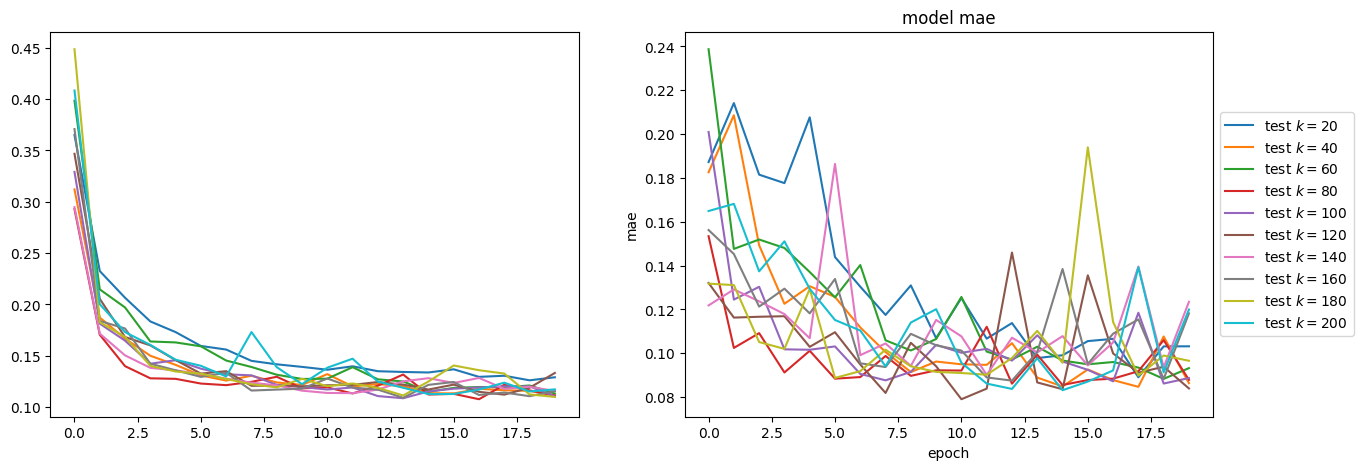

In [331]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i in range(10):
    axes[0].plot(range(20), train_acc_srk[i,:], label=f'train $k={kernel_nums[i]}$')
    axes[1].plot(range(20), test_acc_srk[i,:], label=f'test $k={kernel_nums[i]}$')
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

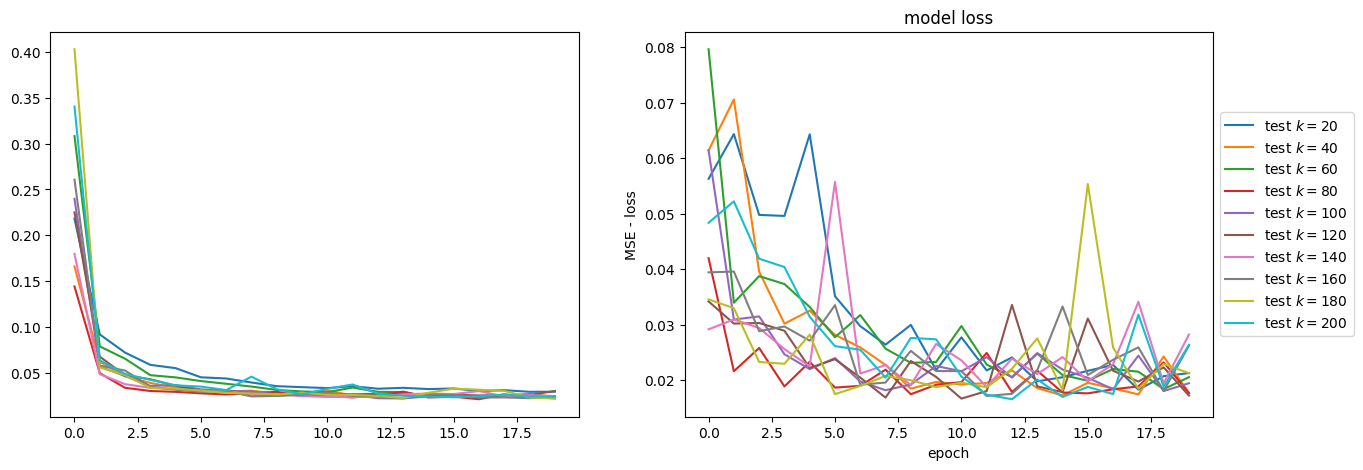

In [332]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i in range(10):
    axes[0].plot(range(20), train_loss_srk[i,:], label=f'train $k={kernel_nums[i]}$')
    axes[1].plot(range(20), test_loss_srk[i,:], label=f'test $k={kernel_nums[i]}$')
plt.title('model loss')
plt.ylabel('MSE - loss')
plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Even though results are pretty similar $k=80$ was picked as one of the best fitted models.

## LSTM

In [333]:
m = 1 #repeat
kernel_nums = [20+20*i for i in range(10)]
n = len(kernel_nums)
train_acc_lk = np.zeros((n,20))
test_acc_lk = np.zeros((n,20))
train_loss_lk = np.zeros((n,20))
test_loss_lk = np.zeros((n,20))
for j in range(m):
    for i in range(n):
        temp_model1_lk = kernel_num_model(keras.layers.LSTM, kernel_nums[i])
        temp_model_lk = temp_model1_lk.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
        train_acc_lk[i,:] = temp_model_lk.history['mae']
        test_acc_lk[i,:] = temp_model_lk.history['val_mae']
        train_loss_lk[i,:] = temp_model_lk.history['loss']
        test_loss_lk[i,:] = temp_model_lk.history['val_loss']
        print(f'ROUND {j*n+i}')

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.5326 - mae: 0.5964 - val_loss: 0.0768 - val_mae: 0.2196
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0941 - mae: 0.2336 - val_loss: 0.0600 - val_mae: 0.1799
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0784 - mae: 0.2121 - val_loss: 0.0578 - val_mae: 0.1747
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0626 - mae: 0.1903 - val_loss: 0.0552 - val_mae: 0.1660
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0628 - mae: 0.1862 - val_loss: 0.0520 - val_mae: 0.1569
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0581 - mae: 0.1818 - val_loss: 0.0490 - val_mae: 0.1525
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0605 - mae: 0.1772 - val_loss: 0.0492 - val_mae: 0.1532
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0583 - mae: 0.1819 - val_loss: 0.0514 - val_mae: 0.1546
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.056

Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0337 - mae: 0.1389 - val_loss: 0.0262 - val_mae: 0.1067
Epoch 16/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0343 - mae: 0.1403 - val_loss: 0.0240 - val_mae: 0.1048
Epoch 17/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0329 - mae: 0.1350 - val_loss: 0.0241 - val_mae: 0.1063
Epoch 18/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0288 - mae: 0.1301 - val_loss: 0.0229 - val_mae: 0.1028
Epoch 19/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0262 - mae: 0.1193 - val_loss: 0.0274 - val_mae: 0.1226
Epoch 20/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0316 - mae: 0.1355 - val_loss: 0.0233 - val_mae: 0.1015
ROUND 2
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - loss: 0.3550 - mae: 0.4605 - val_loss: 0.0709 - val_mae: 0.1962
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.0752 - mae: 0.2119 - val_loss: 0.0538 - val_mae: 0.1643
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 134

30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 0.2462 - mae: 0.3580 - val_loss: 0.0544 - val_mae: 0.1601
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - loss: 0.0602 - mae: 0.1861 - val_loss: 0.0460 - val_mae: 0.1467
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - loss: 0.0502 - mae: 0.1658 - val_loss: 0.0380 - val_mae: 0.1274
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - loss: 0.0533 - mae: 0.1771 - val_loss: 0.0390 - val_mae: 0.1365
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - loss: 0.0426 - mae: 0.1557 - val_loss: 0.0326 - val_mae: 0.1232
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - loss: 0.0394 - mae: 0.1477 - val_loss: 0.0328 - val_mae: 0.1265
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - loss: 0.0362 - mae: 0.1404 - val_loss: 0.0311 - val_mae: 0.1254
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - loss: 0.0343 - mae: 0.1395 - val_loss: 0.0283 - val_mae: 0.1160
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - loss: 0.0339 

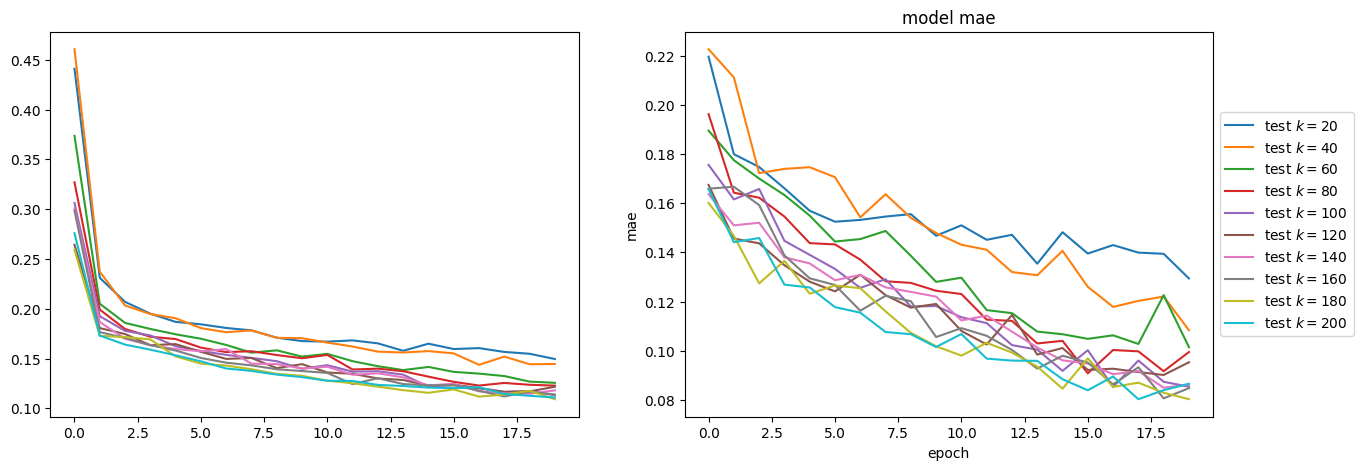

In [334]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i in range(10):
    axes[0].plot(range(20), train_acc_lk[i,:], label=f'train $k={kernel_nums[i]}$')
    axes[1].plot(range(20), test_acc_lk[i,:], label=f'test $k={kernel_nums[i]}$')
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

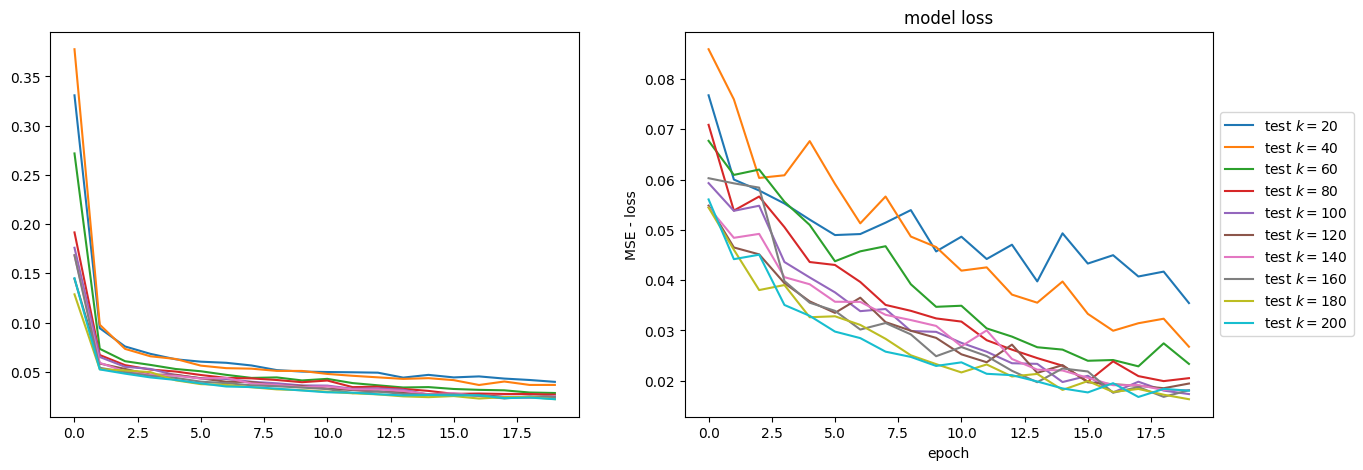

In [335]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i in range(10):
    axes[0].plot(range(20), train_loss_lk[i,:], label=f'train $k={kernel_nums[i]}$')
    axes[1].plot(range(20), test_loss_lk[i,:], label=f'test $k={kernel_nums[i]}$')
plt.title('model loss')
plt.ylabel('MSE - loss')
plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Even though results are pretty similar $k=200$ was picked as one of the best fitted models.

## GRU

In [336]:
m = 1 #repeat
kernel_nums = [20+20*i for i in range(10)]
n = len(kernel_nums)
train_acc_gk = np.zeros((n,20))
test_acc_gk = np.zeros((n,20))
train_loss_gk = np.zeros((n,20))
test_loss_gk = np.zeros((n,20))
for j in range(m):
    for i in range(n):
        temp_model1_gk = kernel_num_model(keras.layers.GRU, kernel_nums[i])
        temp_model_gk = temp_model1_gk.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
        train_acc_gk[i,:] = temp_model_gk.history['mae']
        test_acc_gk[i,:] = temp_model_gk.history['val_mae']
        train_loss_gk[i,:] = temp_model_gk.history['loss']
        test_loss_gk[i,:] = temp_model_gk.history['val_loss']
        print(f'ROUND {j*n+i}')

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.5211 - mae: 0.5740 - val_loss: 0.0652 - val_mae: 0.1928
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0748 - mae: 0.2144 - val_loss: 0.0430 - val_mae: 0.1546
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0574 - mae: 0.1841 - val_loss: 0.0378 - val_mae: 0.1395
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0567 - mae: 0.1782 - val_loss: 0.0343 - val_mae: 0.1308
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0494 - mae: 0.1675 - val_loss: 0.0336 - val_mae: 0.1313
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0478 - mae: 0.1653 - val_loss: 0.0315 - val_mae: 0.1265
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0443 - mae: 0.1615 - val_loss: 0.0300 - val_mae: 0.1199
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0435 - mae: 0.1566 - val_loss: 0.0294 - val_mae: 0.1212
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.035

Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0253 - mae: 0.1202 - val_loss: 0.0177 - val_mae: 0.0852
Epoch 16/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0248 - mae: 0.1154 - val_loss: 0.0180 - val_mae: 0.0854
Epoch 17/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0251 - mae: 0.1197 - val_loss: 0.0165 - val_mae: 0.0815
Epoch 18/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0274 - mae: 0.1198 - val_loss: 0.0161 - val_mae: 0.0799
Epoch 19/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0199 - mae: 0.1032 - val_loss: 0.0163 - val_mae: 0.0818
Epoch 20/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0223 - mae: 0.1105 - val_loss: 0.0156 - val_mae: 0.0783
ROUND 2
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - loss: 0.3843 - mae: 0.4473 - val_loss: 0.0359 - val_mae: 0.1327
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0415 - mae: 0.1562 - val_loss: 0.0316 - val_mae: 0.1223
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 1

30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 0.3388 - mae: 0.4037 - val_loss: 0.0285 - val_mae: 0.1187
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0337 - mae: 0.1401 - val_loss: 0.0238 - val_mae: 0.1049
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0284 - mae: 0.1252 - val_loss: 0.0215 - val_mae: 0.0970
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0281 - mae: 0.1255 - val_loss: 0.0205 - val_mae: 0.0929
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0254 - mae: 0.1164 - val_loss: 0.0204 - val_mae: 0.0961
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0246 - mae: 0.1149 - val_loss: 0.0179 - val_mae: 0.0852
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0247 - mae: 0.1132 - val_loss: 0.0170 - val_mae: 0.0826
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0262 - mae: 0.1203 - val_loss: 0.0171 - val_mae: 0.0827
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0221 -

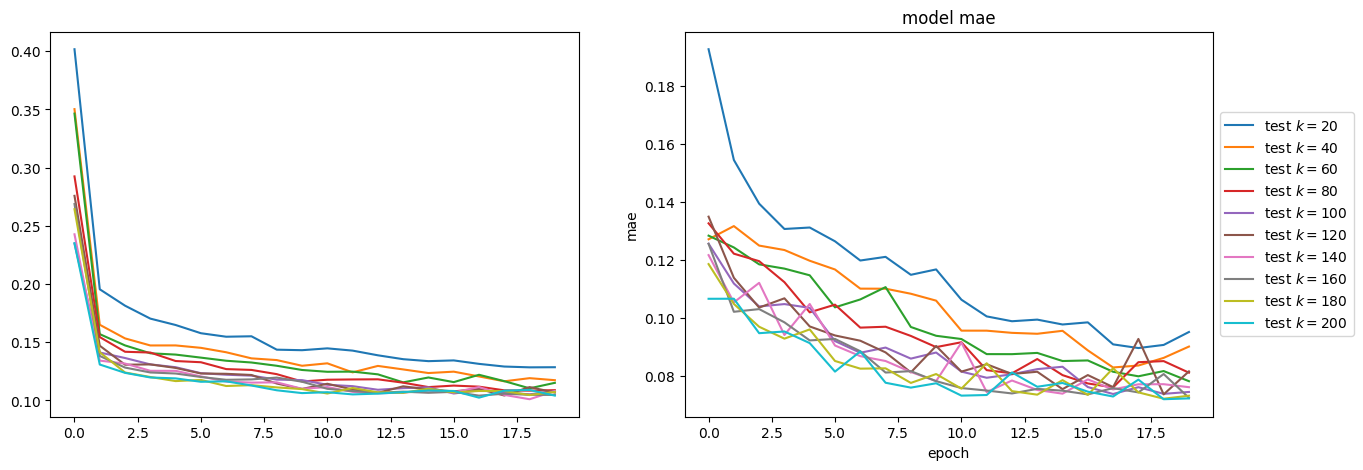

In [337]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i in range(10):
    axes[0].plot(range(20), train_acc_gk[i,:], label=f'train $k={kernel_nums[i]}$')
    axes[1].plot(range(20), test_acc_gk[i,:], label=f'test $k={kernel_nums[i]}$')
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

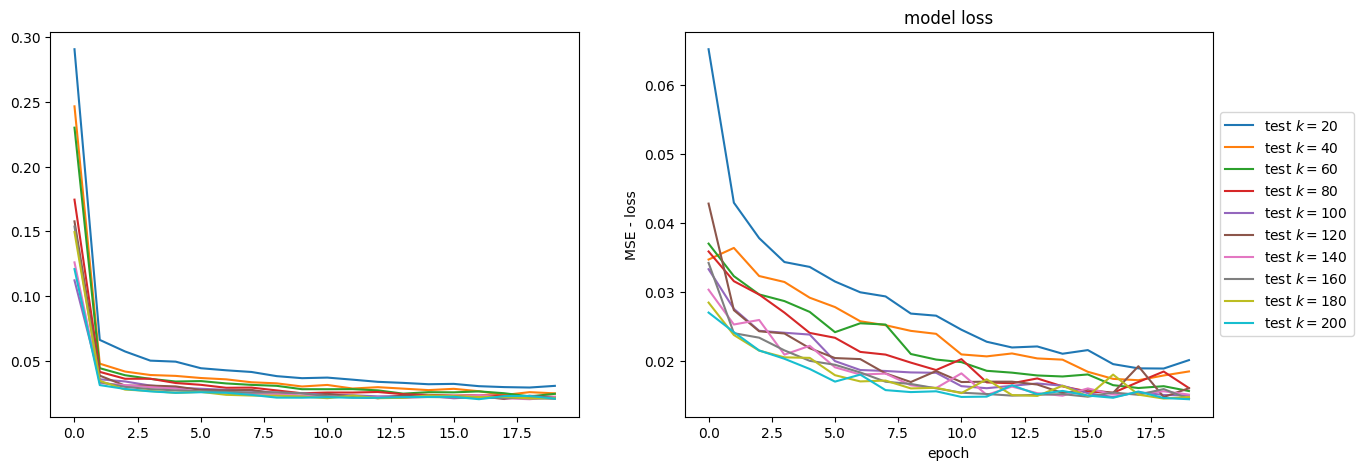

In [338]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i in range(10):
    axes[0].plot(range(20), train_loss_gk[i,:], label=f'train $k={kernel_nums[i]}$')
    axes[1].plot(range(20), test_loss_gk[i,:], label=f'test $k={kernel_nums[i]}$')
plt.title('model loss')
plt.ylabel('MSE - loss')
plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Even though results are pretty similar $k=200$ was picked as one of the best fitted models.

# Dropout layer changes

In [45]:
def dropout_model(layer, drop):
    dmodel = keras.Sequential()
    dmodel.add(layer(128, input_shape=(50,1), return_sequences=True))
    dmodel.add(keras.layers.Dropout(drop))
    dmodel.add(layer(128))
    dmodel.add(keras.layers.Dense(1))
    dmodel.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])
    return dmodel

## SimpleRNN

In [63]:
m = 1 #repeat
n = 10
train_acc_srd = np.zeros((n,20))
test_acc_srd = np.zeros((n,20))
train_loss_srd = np.zeros((n,20))
test_loss_srd = np.zeros((n,20))
for j in range(m):
    for i in range(n):
        temp_model1_srd = dropout_model(keras.layers.SimpleRNN, i*0.1)
        temp_model_srd = temp_model1_srd.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
        train_acc_srd[i,:] = temp_model_srd.history['mae']
        test_acc_srd[i,:] = temp_model_srd.history['val_mae']
        train_loss_srd[i,:] = temp_model_srd.history['loss']
        test_loss_srd[i,:] = temp_model_srd.history['val_loss']
        print(f'ROUND {j*n+i}')

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.5192 - mae: 0.5307 - val_loss: 0.0584 - val_mae: 0.1834
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0363 - mae: 0.1456 - val_loss: 0.0347 - val_mae: 0.1454
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0233 - mae: 0.1118 - val_loss: 0.0257 - val_mae: 0.1141
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0234 - mae: 0.1176 - val_loss: 0.0239 - val_mae: 0.1076
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0212 - mae: 0.1074 - val_loss: 0.0224 - val_mae: 0.1053
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0185 - mae: 0.1008 - val_loss: 0.0237 - val_mae: 0.1063
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0224 - mae: 0.1094 - val_loss: 0.0248 - val_mae: 0.1069
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0175 - mae: 0.0977 - val_loss: 0.0278 - val_mae: 0.1152
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.021

Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0219 - mae: 0.1136 - val_loss: 0.0242 - val_mae: 0.1034
Epoch 16/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0203 - mae: 0.1091 - val_loss: 0.0228 - val_mae: 0.1005
Epoch 17/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0234 - mae: 0.1115 - val_loss: 0.0292 - val_mae: 0.1246
Epoch 18/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0224 - mae: 0.1133 - val_loss: 0.0250 - val_mae: 0.1136
Epoch 19/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0292 - mae: 0.1261 - val_loss: 0.0235 - val_mae: 0.1069
Epoch 20/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0219 - mae: 0.1106 - val_loss: 0.0197 - val_mae: 0.0939
ROUND 2
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.2137 - mae: 0.3697 - val_loss: 0.0367 - val_mae: 0.1484
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0535 - mae: 0.1779 - val_loss: 0.0206 - val_mae: 0.0958
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0439 - mae: 0.1585 - val_loss: 0.0805 - val_mae: 0.2281
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0554 - mae: 0.1823 - val_loss: 0.0527 - val_mae: 0.1776
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0487 - mae: 0.1706 - val_loss: 0.0230 - val_mae: 0.1005
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0380 - mae: 0.1477 - val_loss: 0.0224 - val_mae: 0.1005
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0348 - mae: 0.1378 - val_loss: 0.0194 - val_mae: 0.0878
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0382 - mae: 0.1441 - val_loss: 0.0219 - val_mae: 0.0974
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0296 - mae: 0.1302 - val_loss: 0.0257 - val_mae: 0.1127
Epoch 16/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0280 - mae: 0.1245 - val_loss: 0.0259 - val_mae: 0.1159
Epoch 17/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - los

Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1071 - mae: 0.2562 - val_loss: 0.0535 - val_mae: 0.1733
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0747 - mae: 0.2135 - val_loss: 0.0593 - val_mae: 0.1793
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0940 - mae: 0.2284 - val_loss: 0.0432 - val_mae: 0.1521
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0643 - mae: 0.1959 - val_loss: 0.0339 - val_mae: 0.1403
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0696 - mae: 0.1985 - val_loss: 0.0406 - val_mae: 0.1517
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0554 - mae: 0.1774 - val_loss: 0.0486 - val_mae: 0.1772
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0513 - mae: 0.1774 - val_loss: 0.0271 - val_mae: 0.1246
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0527 - mae: 0.1747 - val_loss: 0.0266 - val_mae: 0.1135
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0

In [64]:
temp_model1_srd = dropout_model(keras.layers.SimpleRNN, 0.99)
temp_model_srd = temp_model1_srd.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 1.7168 - mae: 1.0433 - val_loss: 6.8647 - val_mae: 2.2805
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.9727 - mae: 0.7819 - val_loss: 10.0637 - val_mae: 2.7526
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.5949 - mae: 0.6066 - val_loss: 10.1302 - val_mae: 3.0015
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.5246 - mae: 0.5645 - val_loss: 7.8094 - val_mae: 2.5193
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.4954 - mae: 0.5555 - val_loss: 10.6902 - val_mae: 3.1713
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.4797 - mae: 0.5454 - val_loss: 9.5896 - val_mae: 3.0383
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.4955 - mae: 0.5489 - val_loss: 8.1889 - val_mae: 2.7086
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.4526 - mae: 0.5399 - val_loss: 10.1209 - val_mae: 3.1276
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0

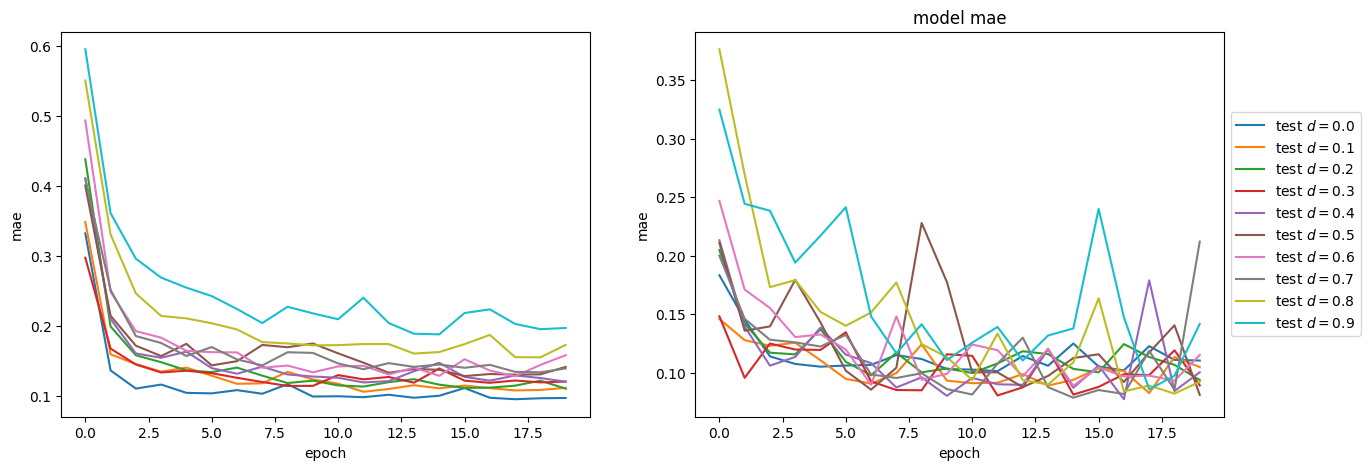

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i in range(10):
    axes[0].plot(range(20), train_acc_srd[i,:], label=f'train $d={round(i*0.1,1)}$')
    axes[1].plot(range(20), test_acc_srd[i,:], label=f'test $d={round(i*0.1,1)}$')
axes[0].set_ylabel('mae')
axes[0].set_xlabel('epoch')
axes[1].set_title('model mae')
axes[1].set_ylabel('mae')
axes[1].set_xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

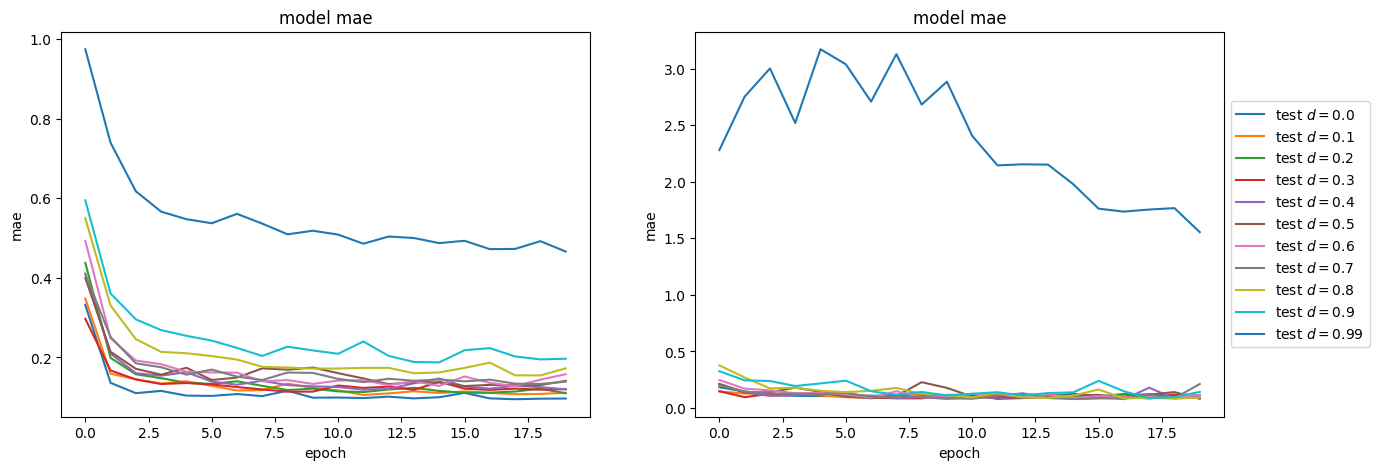

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i in range(10):
    axes[0].plot(range(20), train_acc_srd[i,:], label=f'train $d={round(i*0.1,1)}$')
    axes[1].plot(range(20), test_acc_srd[i,:], label=f'test $d={round(i*0.1,1)}$')
axes[0].plot(range(20), temp_model_srd.history['mae'], label='train $d=0.99$')
axes[1].plot(range(20), temp_model_srd.history['val_mae'], label='test $d=0.99$')
axes[0].set_title('model mae')
axes[0].set_ylabel('mae')
axes[0].set_xlabel('epoch')
axes[1].set_title('model mae')
axes[1].set_ylabel('mae')
axes[1].set_xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

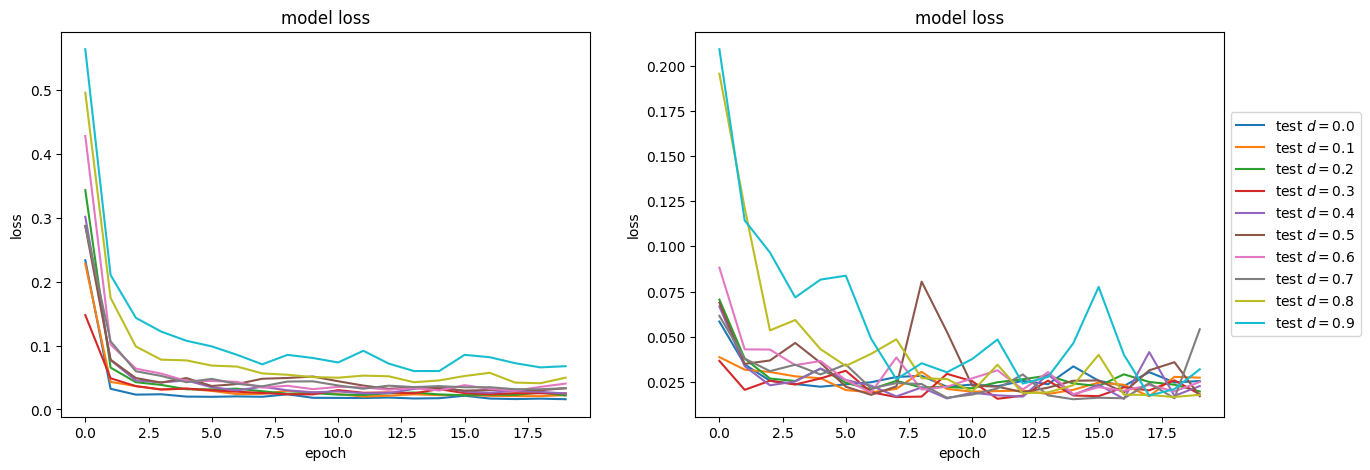

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i in range(10):
    axes[0].plot(range(20), train_loss_srd[i,:], label=f'train $d={round(i*0.1,1)}$')
    axes[1].plot(range(20), test_loss_srd[i,:], label=f'test $d={round(i*0.1,1)}$')
axes[0].set_title('model loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

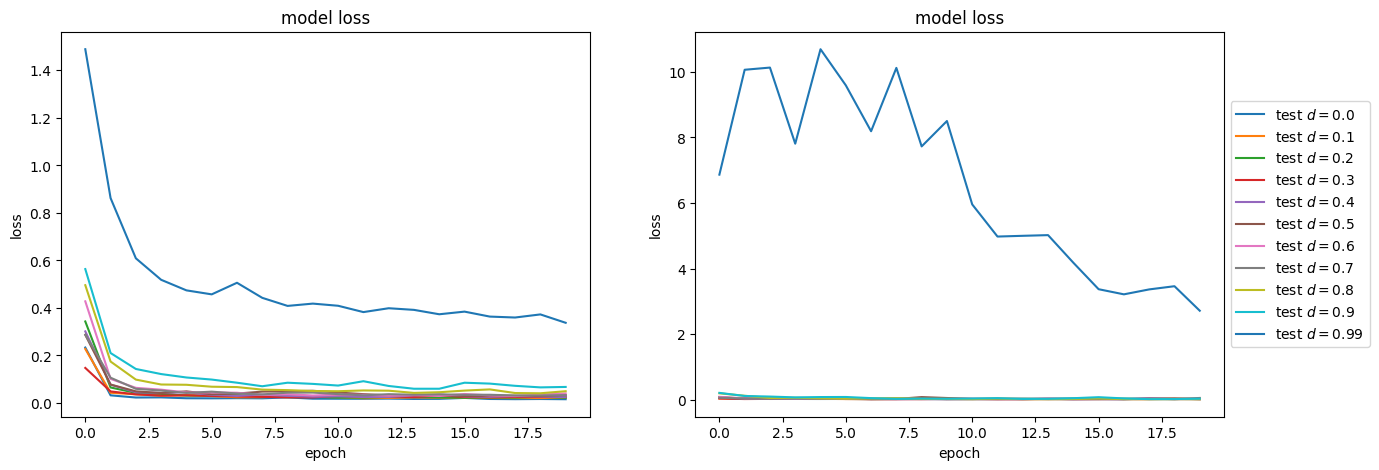

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i in range(10):
    axes[0].plot(range(20), train_loss_srd[i,:], label=f'train $d={round(i*0.1,1)}$')
    axes[1].plot(range(20), test_loss_srd[i,:], label=f'test $d={round(i*0.1,1)}$')
axes[0].plot(range(20), temp_model_srd.history['loss'], label='train $d=0.99$')
axes[1].plot(range(20), temp_model_srd.history['val_loss'], label='test $d=0.99$')
axes[0].set_title('model loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

$d=0.3$ was picked as one of the best fitted models.

## LSTM

In [68]:
m = 1 #repeat
n = 10
train_acc_ld = np.zeros((n,20))
test_acc_ld = np.zeros((n,20))
train_loss_ld = np.zeros((n,20))
test_loss_ld = np.zeros((n,20))
for j in range(m):
    for i in range(n):
        temp_model1_ld = dropout_model(keras.layers.LSTM, i*0.1)
        temp_model_ld = temp_model1_ld.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
        train_acc_ld[i,:] = temp_model_ld.history['mae']
        test_acc_ld[i,:] = temp_model_ld.history['val_mae']
        train_loss_ld[i,:] = temp_model_ld.history['loss']
        test_loss_ld[i,:] = temp_model_ld.history['val_loss']
        print(f'ROUND {j*n+i}')

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.3762 - mae: 0.4531 - val_loss: 0.0588 - val_mae: 0.1749
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0579 - mae: 0.1810 - val_loss: 0.0529 - val_mae: 0.1584
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0512 - mae: 0.1713 - val_loss: 0.0608 - val_mae: 0.1652
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0529 - mae: 0.1762 - val_loss: 0.0448 - val_mae: 0.1468
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0473 - mae: 0.1631 - val_loss: 0.0433 - val_mae: 0.1457
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0400 - mae: 0.1491 - val_loss: 0.0362 - val_mae: 0.1298
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0418 - mae: 0.1534 - val_loss: 0.0360 - val_mae: 0.1329
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0406 - mae: 0.1474 - val_loss: 0.0357 - val_mae: 0.1333
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.040

Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0277 - mae: 0.1266 - val_loss: 0.0215 - val_mae: 0.0960
Epoch 16/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0260 - mae: 0.1179 - val_loss: 0.0206 - val_mae: 0.0967
Epoch 17/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0246 - mae: 0.1172 - val_loss: 0.0188 - val_mae: 0.0870
Epoch 18/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0278 - mae: 0.1229 - val_loss: 0.0198 - val_mae: 0.0900
Epoch 19/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0242 - mae: 0.1196 - val_loss: 0.0181 - val_mae: 0.0853
Epoch 20/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0244 - mae: 0.1152 - val_loss: 0.0177 - val_mae: 0.0863
ROUND 2
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.3042 - mae: 0.4165 - val_loss: 0.0526 - val_mae: 0.1572
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0618 - mae: 0.1877 - val_loss: 0.0497 - val_mae: 0.1520
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step

Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0440 - mae: 0.1599 - val_loss: 0.0360 - val_mae: 0.1377
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0436 - mae: 0.1582 - val_loss: 0.0311 - val_mae: 0.1226
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0422 - mae: 0.1517 - val_loss: 0.0282 - val_mae: 0.1161
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0333 - mae: 0.1386 - val_loss: 0.0337 - val_mae: 0.1236
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0375 - mae: 0.1473 - val_loss: 0.0266 - val_mae: 0.1135
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0357 - mae: 0.1406 - val_loss: 0.0242 - val_mae: 0.1056
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0340 - mae: 0.1404 - val_loss: 0.0238 - val_mae: 0.1055
Epoch 16/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0353 - mae: 0.1421 - val_loss: 0.0279 - val_mae: 0.1096
Epoch 17/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - los

Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0624 - mae: 0.1907 - val_loss: 0.0590 - val_mae: 0.1659
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0604 - mae: 0.1918 - val_loss: 0.0475 - val_mae: 0.1513
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0611 - mae: 0.1856 - val_loss: 0.0440 - val_mae: 0.1458
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0580 - mae: 0.1810 - val_loss: 0.0439 - val_mae: 0.1480
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0513 - mae: 0.1752 - val_loss: 0.0406 - val_mae: 0.1407
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0577 - mae: 0.1804 - val_loss: 0.0416 - val_mae: 0.1368
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0525 - mae: 0.1794 - val_loss: 0.0373 - val_mae: 0.1365
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0468 - mae: 0.1626 - val_loss: 0.0360 - val_mae: 0.1339
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0

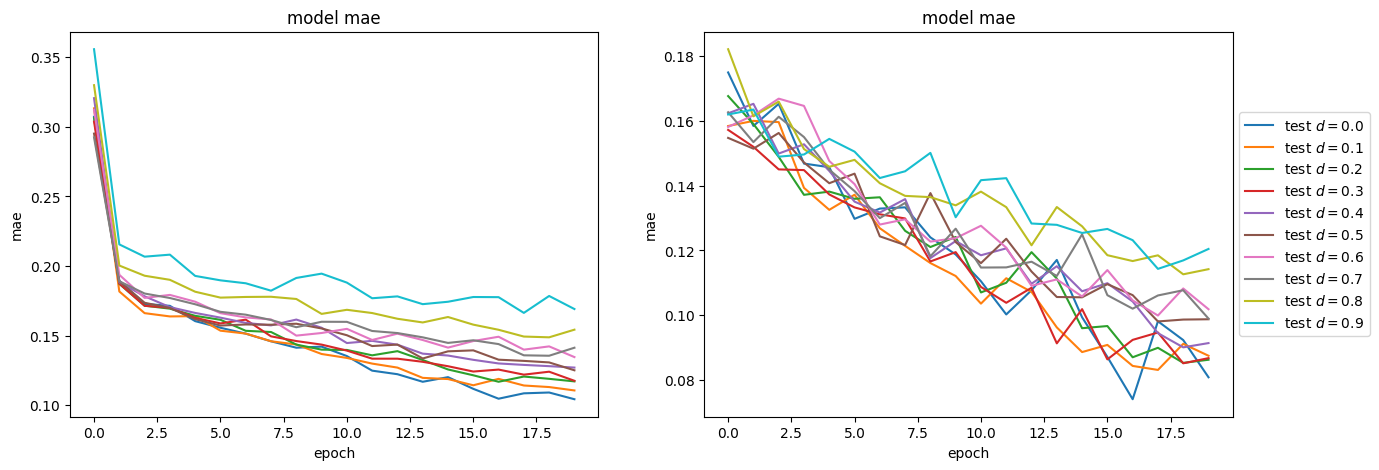

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i in range(10):
    axes[0].plot(range(20), train_acc_ld[i,:], label=f'train $d={round(i*0.1,1)}$')
    axes[1].plot(range(20), test_acc_ld[i,:], label=f'test $d={round(i*0.1,1)}$')
axes[0].set_title('model mae')
axes[0].set_ylabel('mae')
axes[0].set_xlabel('epoch')
axes[1].set_title('model mae')
axes[1].set_ylabel('mae')
axes[1].set_xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

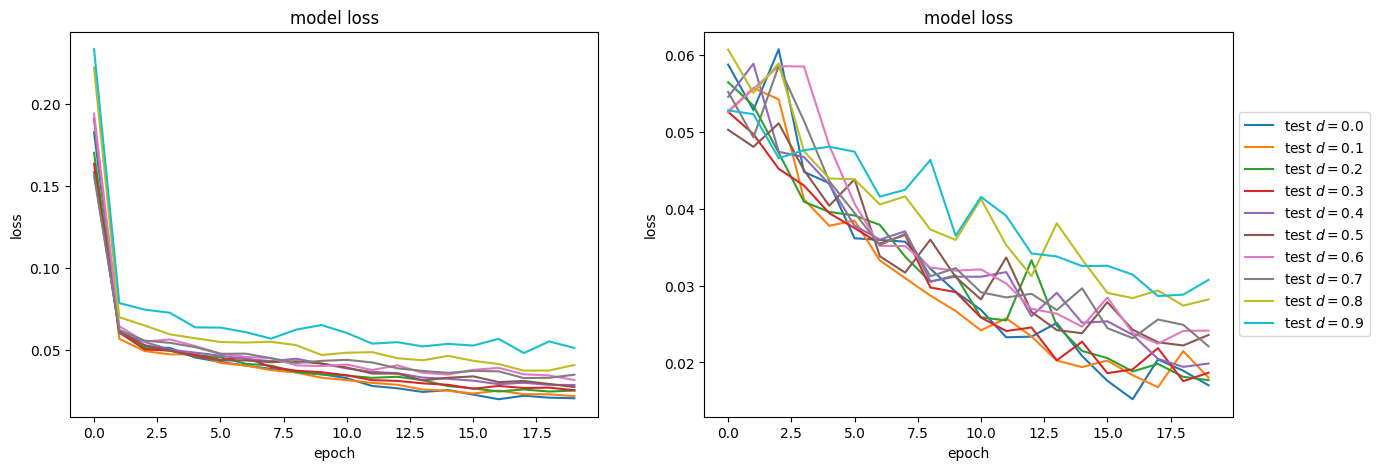

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i in range(10):
    axes[0].plot(range(20), train_loss_ld[i,:], label=f'train $d={round(i*0.1,1)}$')
    axes[1].plot(range(20), test_loss_ld[i,:], label=f'test $d={round(i*0.1,1)}$')
axes[0].set_title('model loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

$d=0.1$ was picked as one of the best fitted models.

## GRU

In [71]:
m = 1 #repeat
n = 10
train_acc_gd = np.zeros((n,20))
test_acc_gd = np.zeros((n,20))
train_loss_gd = np.zeros((n,20))
test_loss_gd = np.zeros((n,20))
for j in range(m):
    for i in range(n):
        temp_model1_gd = dropout_model(keras.layers.GRU, i*0.1)
        temp_model_gd = temp_model1_gd.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
        train_acc_gd[i,:] = temp_model_gd.history['mae']
        test_acc_gd[i,:] = temp_model_gd.history['val_mae']
        train_loss_gd[i,:] = temp_model_gd.history['loss']
        test_loss_gd[i,:] = temp_model_gd.history['val_loss']
        print(f'ROUND {j*n+i}')

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 0.4004 - mae: 0.4434 - val_loss: 0.0340 - val_mae: 0.1234
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0348 - mae: 0.1412 - val_loss: 0.0245 - val_mae: 0.1045
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0280 - mae: 0.1232 - val_loss: 0.0228 - val_mae: 0.1025
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0244 - mae: 0.1155 - val_loss: 0.0207 - val_mae: 0.0956
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0271 - mae: 0.1230 - val_loss: 0.0194 - val_mae: 0.0916
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0214 - mae: 0.1072 - val_loss: 0.0182 - val_mae: 0.0874
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0218 - mae: 0.1079 - val_loss: 0.0181 - val_mae: 0.0876
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0203 - mae: 0.1044 - val_loss: 0.0182 - val_mae: 0.0861
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 

Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0228 - mae: 0.1098 - val_loss: 0.0176 - val_mae: 0.0843
Epoch 16/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0237 - mae: 0.1141 - val_loss: 0.0154 - val_mae: 0.0763
Epoch 17/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0213 - mae: 0.1062 - val_loss: 0.0183 - val_mae: 0.0903
Epoch 18/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0223 - mae: 0.1110 - val_loss: 0.0148 - val_mae: 0.0734
Epoch 19/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0247 - mae: 0.1117 - val_loss: 0.0150 - val_mae: 0.0746
Epoch 20/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0202 - mae: 0.1051 - val_loss: 0.0150 - val_mae: 0.0757
ROUND 2
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - loss: 0.2758 - mae: 0.3872 - val_loss: 0.0378 - val_mae: 0.1293
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0394 - mae: 0.1496 - val_loss: 0.0248 - val_mae: 0.1031
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/st

Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0304 - mae: 0.1305 - val_loss: 0.0188 - val_mae: 0.0904
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0296 - mae: 0.1296 - val_loss: 0.0174 - val_mae: 0.0829
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0279 - mae: 0.1249 - val_loss: 0.0181 - val_mae: 0.0847
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0282 - mae: 0.1254 - val_loss: 0.0188 - val_mae: 0.0941
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0244 - mae: 0.1180 - val_loss: 0.0166 - val_mae: 0.0825
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0264 - mae: 0.1220 - val_loss: 0.0162 - val_mae: 0.0797
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0223 - mae: 0.1112 - val_loss: 0.0180 - val_mae: 0.0901
Epoch 16/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0254 - mae: 0.1174 - val_loss: 0.0161 - val_mae: 0.0793
Epoch 17/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - lo

Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0544 - mae: 0.1843 - val_loss: 0.0275 - val_mae: 0.1102
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0492 - mae: 0.1694 - val_loss: 0.0320 - val_mae: 0.1296
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0533 - mae: 0.1726 - val_loss: 0.0254 - val_mae: 0.1052
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0427 - mae: 0.1561 - val_loss: 0.0274 - val_mae: 0.1105
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0423 - mae: 0.1549 - val_loss: 0.0252 - val_mae: 0.1101
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0402 - mae: 0.1551 - val_loss: 0.0232 - val_mae: 0.0978
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0390 - mae: 0.1528 - val_loss: 0.0226 - val_mae: 0.1003
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0368 - mae: 0.1477 - val_loss: 0.0218 - val_mae: 0.1009
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss

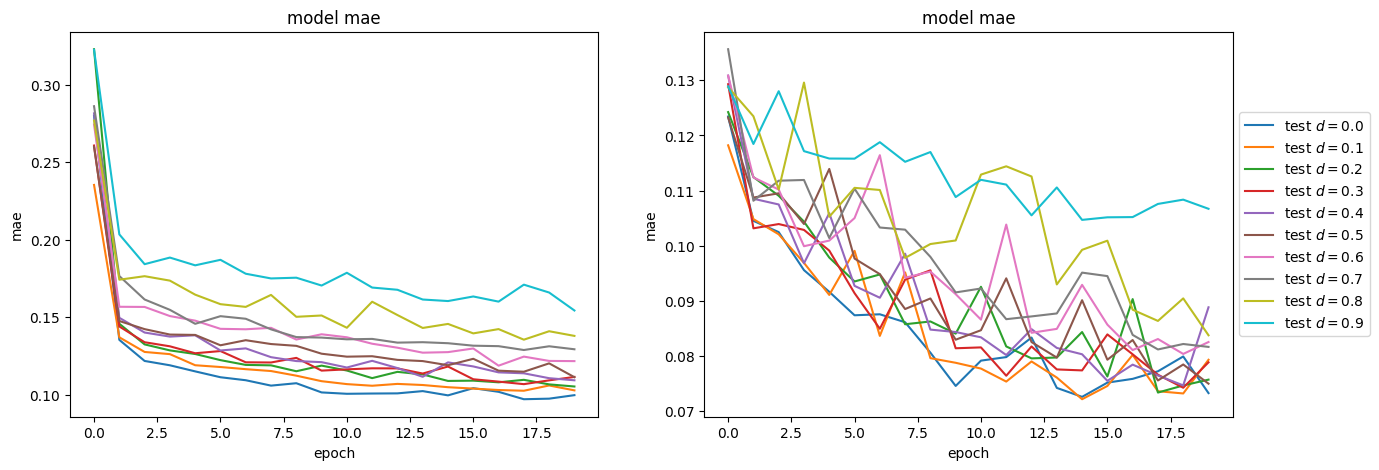

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i in range(10):
    axes[0].plot(range(20), train_acc_gd[i,:], label=f'train $d={round(i*0.1,1)}$')
    axes[1].plot(range(20), test_acc_gd[i,:], label=f'test $d={round(i*0.1,1)}$')
axes[0].set_title('model mae')
axes[0].set_ylabel('mae')
axes[0].set_xlabel('epoch')
axes[1].set_title('model mae')
axes[1].set_ylabel('mae')
axes[1].set_xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

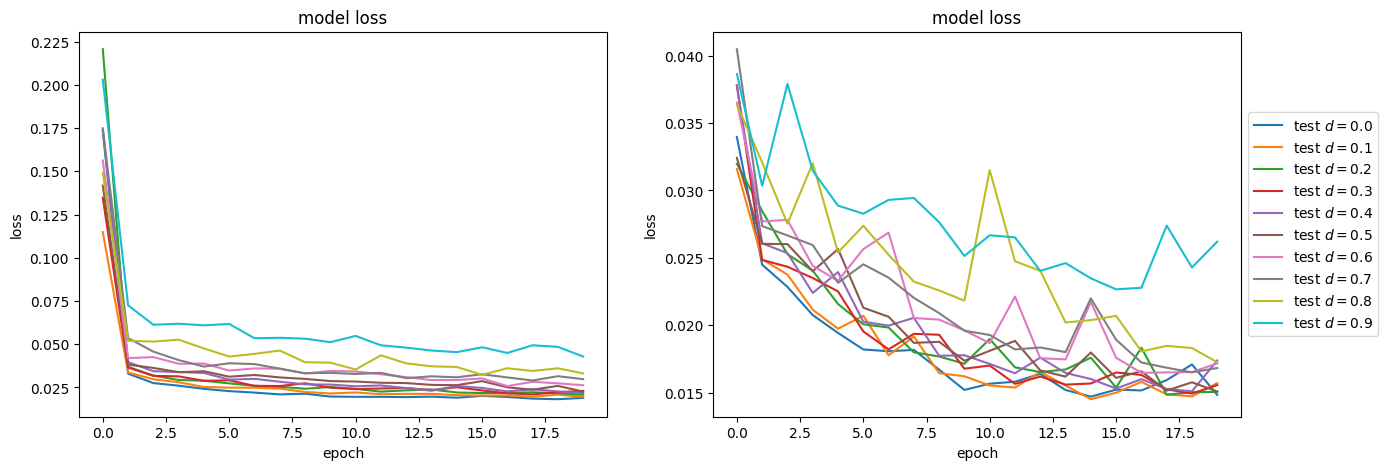

In [77]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for i in range(10):
    axes[0].plot(range(20), train_loss_gd[i,:], label=f'train $d={round(i*0.1,1)}$')
    axes[1].plot(range(20), test_loss_gd[i,:], label=f'test $d={round(i*0.1,1)}$')
axes[0].set_title('model loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

$d=0$ was picked as one of the best fitted models.

# Best model comparison

In [81]:
def get_model(layer,k,drop):
    tmodel = keras.Sequential()
    tmodel.add(layer(k, input_shape=(50,1), return_sequences=True))
    tmodel.add(keras.layers.Dropout(drop))
    tmodel.add(layer(k))
    tmodel.add(keras.layers.Dense(1))
    tmodel.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])
    return tmodel

In [90]:
#BEST SimpleRNN
bestsrk = get_model(keras.layers.SimpleRNN, 80, 0.2)
bestsrd = get_model(keras.layers.SimpleRNN, 128, 0.3)

#BEST LSTM
bestlk = get_model(keras.layers.LSTM, 200, 0.2)
bestld = get_model(keras.layers.LSTM, 128, 0.1)

#BEST GRU
bestgk = get_model(keras.layers.GRU, 200, 0.2)
bestgd = get_model(keras.layers.GRU, 128, 0)

In [91]:
#BEST SimpleRNN
model_srk = bestsrk.fit(x_train, y_train, epochs=40, validation_data=(x_test, y_test))
model_srd = bestsrd.fit(x_train, y_train, epochs=40, validation_data=(x_test, y_test))

Epoch 1/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 0.5062 - mae: 0.5248 - val_loss: 0.0678 - val_mae: 0.2079
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0814 - mae: 0.2237 - val_loss: 0.0452 - val_mae: 0.1588
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0586 - mae: 0.1834 - val_loss: 0.0293 - val_mae: 0.1220
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0431 - mae: 0.1609 - val_loss: 0.0252 - val_mae: 0.1124
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0362 - mae: 0.1439 - val_loss: 0.0262 - val_mae: 0.1105
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0304 - mae: 0.1333 - val_loss: 0.0217 - val_mae: 0.1017
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0295 - mae: 0.1312 - val_loss: 0.0201 - val_mae: 0.0975
Epoch 8/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0320 - mae: 0.1359 - val_loss: 0.0197 - val_mae: 0.1004
Epoch 9/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.028

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0308 - mae: 0.1321 - val_loss: 0.0224 - val_mae: 0.1006
Epoch 16/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0247 - mae: 0.1188 - val_loss: 0.0211 - val_mae: 0.0959
Epoch 17/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0208 - mae: 0.1082 - val_loss: 0.0194 - val_mae: 0.0932
Epoch 18/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0243 - mae: 0.1186 - val_loss: 0.0378 - val_mae: 0.1587
Epoch 19/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0269 - mae: 0.1283 - val_loss: 0.0238 - val_mae: 0.1009
Epoch 20/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0250 - mae: 0.1199 - val_loss: 0.0227 - val_mae: 0.1044
Epoch 21/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0241 - mae: 0.1195 - val_loss: 0.0191 - val_mae: 0.0904
Epoch 22/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0296 - mae: 0.1321 - val_loss: 0.0209 - val_mae: 0.1021
Epoch 23/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0237 -

In [92]:
#BEST LSTM
model_lk = bestlk.fit(x_train, y_train, epochs=40, validation_data=(x_test, y_test))
model_ld = bestld.fit(x_train, y_train, epochs=40, validation_data=(x_test, y_test))

Epoch 1/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 235ms/step - loss: 0.2868 - mae: 0.3746 - val_loss: 0.0459 - val_mae: 0.1434
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - loss: 0.0562 - mae: 0.1778 - val_loss: 0.0546 - val_mae: 0.1585
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - loss: 0.0510 - mae: 0.1683 - val_loss: 0.0410 - val_mae: 0.1420
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - loss: 0.0437 - mae: 0.1558 - val_loss: 0.0378 - val_mae: 0.1292
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - loss: 0.0426 - mae: 0.1572 - val_loss: 0.0318 - val_mae: 0.1223
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - loss: 0.0386 - mae: 0.1467 - val_loss: 0.0316 - val_mae: 0.1247
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - loss: 0.0356 - mae: 0.1390 - val_loss: 0.0313 - val_mae: 0.1268
Epoch 8/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - loss: 0.0383 - mae: 0.1486 - val_loss: 0.0247 - val_mae: 0.1046
Epoch 9/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step - l

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - loss: 0.0255 - mae: 0.1226 - val_loss: 0.0230 - val_mae: 0.1035
Epoch 15/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - loss: 0.0284 - mae: 0.1226 - val_loss: 0.0200 - val_mae: 0.0901
Epoch 16/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - loss: 0.0242 - mae: 0.1161 - val_loss: 0.0168 - val_mae: 0.0802
Epoch 17/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.0235 - mae: 0.1154 - val_loss: 0.0184 - val_mae: 0.0848
Epoch 18/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.0225 - mae: 0.1079 - val_loss: 0.0157 - val_mae: 0.0766
Epoch 19/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - loss: 0.0241 - mae: 0.1178 - val_loss: 0.0163 - val_mae: 0.0785
Epoch 20/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - loss: 0.0248 - mae: 0.1153 - val_loss: 0.0165 - val_mae: 0.0822
Epoch 21/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 0.0231 - mae: 0.1105 - val_loss: 0.0189 - val_mae: 0.0940
Epoch 22/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - loss:

In [93]:
#BEST GRU
model_gk = bestgk.fit(x_train, y_train, epochs=40, validation_data=(x_test, y_test))
model_gd = bestgd.fit(x_train, y_train, epochs=40, validation_data=(x_test, y_test))

Epoch 1/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 324ms/step - loss: 0.3123 - mae: 0.3875 - val_loss: 0.0257 - val_mae: 0.1027
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 313ms/step - loss: 0.0393 - mae: 0.1487 - val_loss: 0.0236 - val_mae: 0.1052
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - loss: 0.0273 - mae: 0.1222 - val_loss: 0.0203 - val_mae: 0.0935
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 265ms/step - loss: 0.0262 - mae: 0.1213 - val_loss: 0.0192 - val_mae: 0.0907
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - loss: 0.0255 - mae: 0.1150 - val_loss: 0.0190 - val_mae: 0.0920
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step - loss: 0.0236 - mae: 0.1145 - val_loss: 0.0174 - val_mae: 0.0855
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - loss: 0.0220 - mae: 0.1089 - val_loss: 0.0207 - val_mae: 0.0921
Epoch 8/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step - loss: 0.0273 - mae: 0.1203 - val_loss: 0.0163 - val_mae: 0.0817
Epoch 9/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - 

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - loss: 0.0188 - mae: 0.0966 - val_loss: 0.0153 - val_mae: 0.0750
Epoch 15/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss: 0.0195 - mae: 0.1005 - val_loss: 0.0145 - val_mae: 0.0723
Epoch 16/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - loss: 0.0165 - mae: 0.0943 - val_loss: 0.0154 - val_mae: 0.0753
Epoch 17/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 0.0205 - mae: 0.1053 - val_loss: 0.0152 - val_mae: 0.0748
Epoch 18/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 0.0204 - mae: 0.1003 - val_loss: 0.0144 - val_mae: 0.0716
Epoch 19/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - loss: 0.0183 - mae: 0.0973 - val_loss: 0.0149 - val_mae: 0.0740
Epoch 20/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - loss: 0.0211 - mae: 0.1037 - val_loss: 0.0179 - val_mae: 0.0856
Epoch 21/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss: 0.0238 - mae: 0.1111 - val_loss: 0.0144 - val_mae: 0.0722
Epoch 22/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss:

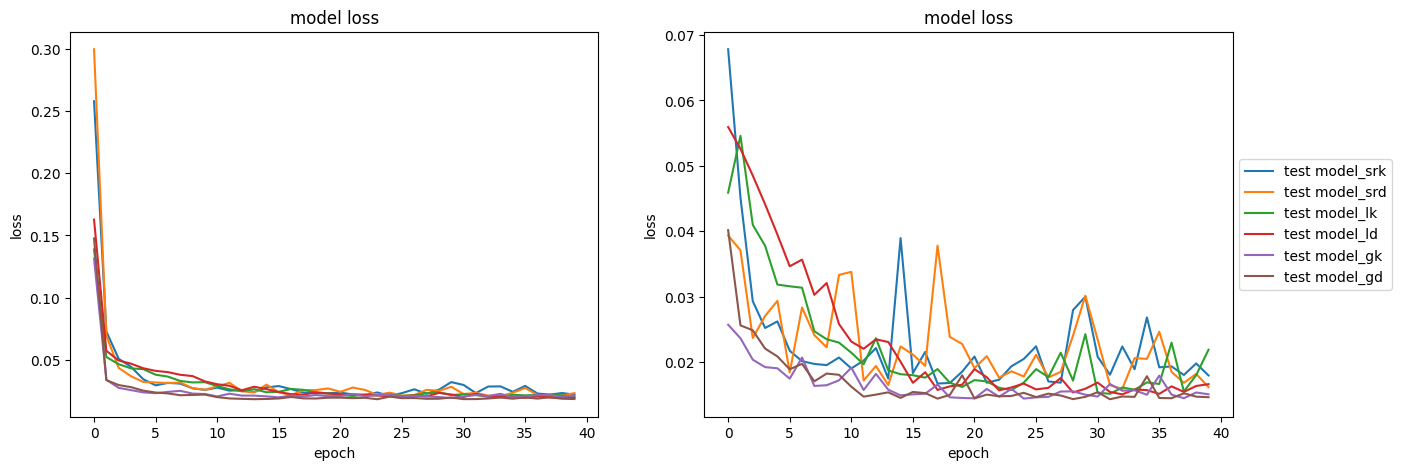

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
models = {'model_srk': model_srk,
          'model_srd': model_srd,
          'model_lk': model_lk,
          'model_ld': model_ld,
          'model_gk': model_gk,
          'model_gd': model_gd,
         }

for name,model in models.items():
    axes[0].plot(range(40), model.history['loss'], label=f'train {name}')
    axes[1].plot(range(40), model.history['val_loss'], label=f'test {name}')
axes[0].set_title('model loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

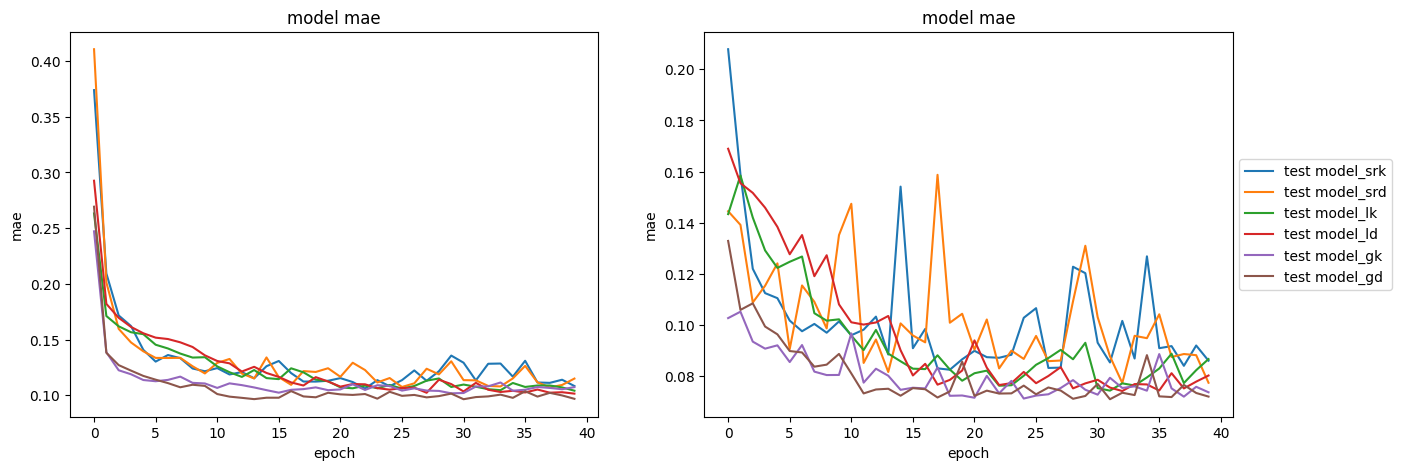

In [95]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for name,model in models.items():
    axes[0].plot(range(40), model.history['mae'], label=f'train {name}')
    axes[1].plot(range(40), model.history['val_mae'], label=f'test {name}')
axes[0].set_title('model mae')
axes[0].set_ylabel('mae')
axes[0].set_xlabel('epoch')
axes[1].set_title('model mae')
axes[1].set_ylabel('mae')
axes[1].set_xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step


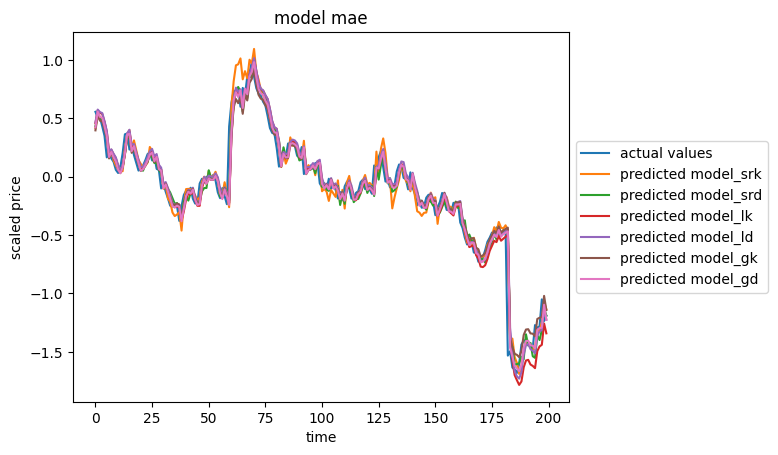

In [96]:
plt.plot(y_test, label='actual values')
models_preds = {'model_srk': bestsrk,
                'model_srd': bestsrd,
                'model_lk': bestlk,
                'model_ld': bestld,
                'model_gk': bestgk,
                'model_gd': bestgd,
               }
for name,model in models_preds.items():
    plt.plot(model.predict(x_test), label=f'predicted {name}')
plt.title('model mae')
plt.ylabel('scaled price')
plt.xlabel('time')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Even though all the models seam to predict values very well, the best model, especially if we decide on smaller number of epochs, is GRU with overall lowest MSE and MAE.